In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/apple-vs-orange-binary-classification/fruit-dataset/orange/266.jpeg
/kaggle/input/apple-vs-orange-binary-classification/fruit-dataset/orange/071.jpeg
/kaggle/input/apple-vs-orange-binary-classification/fruit-dataset/orange/344.jpeg
/kaggle/input/apple-vs-orange-binary-classification/fruit-dataset/orange/228.jpeg
/kaggle/input/apple-vs-orange-binary-classification/fruit-dataset/orange/099.jpeg
/kaggle/input/apple-vs-orange-binary-classification/fruit-dataset/orange/130.jpeg
/kaggle/input/apple-vs-orange-binary-classification/fruit-dataset/orange/158.jpeg
/kaggle/input/apple-vs-orange-binary-classification/fruit-dataset/orange/003.jpeg
/kaggle/input/apple-vs-orange-binary-classification/fruit-dataset/orange/253.jpeg
/kaggle/input/apple-vs-orange-binary-classification/fruit-dataset/orange/014.jpeg
/kaggle/input/apple-vs-orange-binary-classification/fruit-dataset/orange/381.jpeg
/kaggle/input/apple-vs-orange-binary-classification/fruit-dataset/orange/263.jpeg
/kaggle/input/ap

In [2]:
!pip install qai_hub torch torchvision pillow numpy scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.4/103.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitli

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import qai_hub as hub
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import json

In [4]:
# Custom Dataset Class
class AppleOrangeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['apple', 'orange']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(class_dir, img_name)
                        self.samples.append((img_path, self.class_to_idx[class_name]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [5]:
# Qualcomm AI Hub Model Integration
class QualcommAppleOrangeClassifier:
    def __init__(self, model_name="mobilenet_v2"):
        """Initialize with Qualcomm AI Hub optimized model"""
        print(f"Loading {model_name} from Qualcomm AI Hub...")
        
        # Get model from Qualcomm AI Hub [[10]]
        try:
            self.base_model = hub.get_model(model_name)
            print("✅ Successfully loaded model from Qualcomm AI Hub")
        except:
            # Fallback to torchvision if hub not available
            print("Using torchvision MobileNetV2 as fallback")
            import torchvision.models as models
            self.base_model = models.mobilenet_v2(pretrained=True)
        
        # Modify final layer for binary classification
        self.modify_classifier()
        
        # Define transforms
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
        
        self.classes = ['apple', 'orange']
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.base_model.to(self.device)
    
    def modify_classifier(self):
        """Modify the final layer for binary classification"""
        if hasattr(self.base_model, 'classifier'):
            # For MobileNet
            in_features = self.base_model.classifier[-1].in_features
            self.base_model.classifier[-1] = nn.Linear(in_features, 2)
        elif hasattr(self.base_model, 'fc'):
            # For ResNet
            in_features = self.base_model.fc.in_features
            self.base_model.fc = nn.Linear(in_features, 2)
    
    def prepare_data(self, data_path):
        """Prepare training and validation datasets"""
        print("Preparing datasets...")
        
        # Data augmentation for training
        train_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomCrop((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
        
        # Validation transform (no augmentation)
        val_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
        
        # Create datasets
        full_dataset = AppleOrangeDataset(data_path, transform=train_transform)
        
        # Split dataset (80% train, 20% validation)
        train_size = int(0.8 * len(full_dataset))
        val_size = len(full_dataset) - train_size
        
        train_dataset, val_dataset = torch.utils.data.random_split(
            full_dataset, [train_size, val_size]
        )
        
        # Apply validation transform to validation dataset
        val_dataset.dataset.transform = val_transform
        
        # Create data loaders
        self.train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
        self.val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
        
        print(f"✅ Training samples: {len(train_dataset)}")
        print(f"✅ Validation samples: {len(val_dataset)}")
        
        return self.train_loader, self.val_loader
    
    def train_model(self, num_epochs=20, learning_rate=0.001):
        """Train the model"""
        print(f"🏋️ Starting training for {num_epochs} epochs...")
        
        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.base_model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Training history
        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []
        
        best_val_accuracy = 0.0
        best_model_state = None
        
        for epoch in range(num_epochs):
            # Training phase
            self.base_model.train()
            running_loss = 0.0
            correct_predictions = 0
            total_predictions = 0
            
            for inputs, labels in self.train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.base_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_predictions += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()
            
            train_loss = running_loss / len(self.train_loader)
            train_accuracy = 100 * correct_predictions / total_predictions
            
            # Validation phase
            self.base_model.eval()
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for inputs, labels in self.val_loader:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = self.base_model(inputs)
                    loss = criterion(outputs, labels)
                    
                    val_running_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
            
            val_loss = val_running_loss / len(self.val_loader)
            val_accuracy = 100 * val_correct / val_total
            
            # Save best model
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_model_state = self.base_model.state_dict().copy()
            
            # Store metrics
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            
            scheduler.step()
            
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
            print('-' * 50)
        
        # Load best model
        self.base_model.load_state_dict(best_model_state)
        
        # Save training history
        self.training_history = {
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'best_val_accuracy': best_val_accuracy
        }
        
        print(f"✅ Training completed! Best validation accuracy: {best_val_accuracy:.2f}%")
        return self.training_history
    
    def evaluate_model(self):
        """Evaluate the model and generate detailed metrics"""
        print("📊 Evaluating model...")
        
        self.base_model.eval()
        all_predictions = []
        all_labels = []
        all_probabilities = []
        
        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.base_model(inputs)
                probabilities = torch.nn.functional.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)
                
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probabilities.extend(probabilities.cpu().numpy())
        
        # Classification report
        report = classification_report(all_labels, all_predictions, 
                                     target_names=self.classes, output_dict=True)
        
        # Confusion matrix
        cm = confusion_matrix(all_labels, all_predictions)
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=self.classes, yticklabels=self.classes)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig('/kaggle/working/confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Plot training history
        self.plot_training_history()
        
        print("📈 Classification Report:")
        print(classification_report(all_labels, all_predictions, target_names=self.classes))
        
        return {
            'classification_report': report,
            'confusion_matrix': cm.tolist(),
            'predictions': all_predictions,
            'labels': all_labels,
            'probabilities': all_probabilities
        }
    
    def plot_training_history(self):
        """Plot training history"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Loss plot
        ax1.plot(self.training_history['train_losses'], label='Training Loss')
        ax1.plot(self.training_history['val_losses'], label='Validation Loss')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        
        # Accuracy plot
        ax2.plot(self.training_history['train_accuracies'], label='Training Accuracy')
        ax2.plot(self.training_history['val_accuracies'], label='Validation Accuracy')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        
        plt.tight_layout()
        plt.savefig('/kaggle/working/training_history.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def predict_single_image(self, image_path_or_pil):
        """Predict on a single image"""
        self.base_model.eval()
        
        if isinstance(image_path_or_pil, str):
            image = Image.open(image_path_or_pil).convert('RGB')
        else:
            image = image_path_or_pil
        
        input_tensor = self.transform(image).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            output = self.base_model(input_tensor)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            predicted_class = torch.argmax(probabilities, dim=1).item()
            confidence = probabilities[0][predicted_class].item()
        
        return {
            'predicted_class': self.classes[predicted_class],
            'confidence': confidence,
            'probabilities': {
                'apple': probabilities[0][0].item(),
                'orange': probabilities[0][1].item()
            }
        }
    
    def save_model_for_deployment(self, filename='apple_orange_classifier'):
        """Save model for Streamlit deployment"""
        print(f"💾 Saving model for deployment...")
        
        # Save PyTorch model
        torch.save({
            'model_state_dict': self.base_model.state_dict(),
            'classes': self.classes,
            'transform_params': {
                'mean': [0.485, 0.456, 0.406],
                'std': [0.229, 0.224, 0.225]
            }
        }, f'/kaggle/working/{filename}.pt')
        
        # Save complete classifier object
        # Move model to CPU for pickle compatibility
        self.base_model.cpu()
        
        deployment_package = {
            'classifier': self,
            'model_architecture': 'mobilenet_v2',
            'classes': self.classes,
            'training_history': self.training_history if hasattr(self, 'training_history') else None,
            'transform_params': {
                'mean': [0.485, 0.456, 0.406],
                'std': [0.229, 0.224, 0.225]
            }
        }
        
        with open(f'/kaggle/working/{filename}.pkl', 'wb') as f:
            pickle.dump(deployment_package, f)
        
        print(f"✅ Model saved as {filename}.pt and {filename}.pkl")
        print(f"📁 Files available in /kaggle/working/")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


🍎🍊 Apple vs Orange Classification with Qualcomm AI Hub
Loading mobilenet_v2 from Qualcomm AI Hub...
Using torchvision MobileNetV2 as fallback


100%|██████████| 13.6M/13.6M [00:00<00:00, 172MB/s]


📂 Dataset path: /kaggle/input/apple-vs-orange-binary-classification/fruit-dataset
Preparing datasets...
✅ Training samples: 636
✅ Validation samples: 160
🏋️ Starting training for 30 epochs...
Epoch [1/30]
Train Loss: 0.3378, Train Acc: 86.95%
Val Loss: 1.0883, Val Acc: 90.62%
--------------------------------------------------
Epoch [2/30]
Train Loss: 0.1454, Train Acc: 94.03%
Val Loss: 0.1457, Val Acc: 94.38%
--------------------------------------------------
Epoch [3/30]
Train Loss: 0.0973, Train Acc: 95.44%
Val Loss: 0.2214, Val Acc: 94.38%
--------------------------------------------------
Epoch [4/30]
Train Loss: 0.0521, Train Acc: 97.80%
Val Loss: 0.1636, Val Acc: 96.25%
--------------------------------------------------
Epoch [5/30]
Train Loss: 0.0813, Train Acc: 97.48%
Val Loss: 0.3138, Val Acc: 93.75%
--------------------------------------------------
Epoch [6/30]
Train Loss: 0.1159, Train Acc: 96.07%
Val Loss: 0.2622, Val Acc: 93.75%
-------------------------------------------

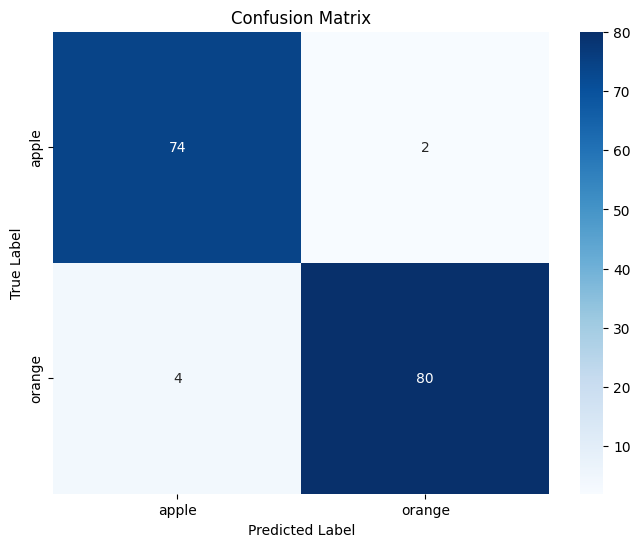

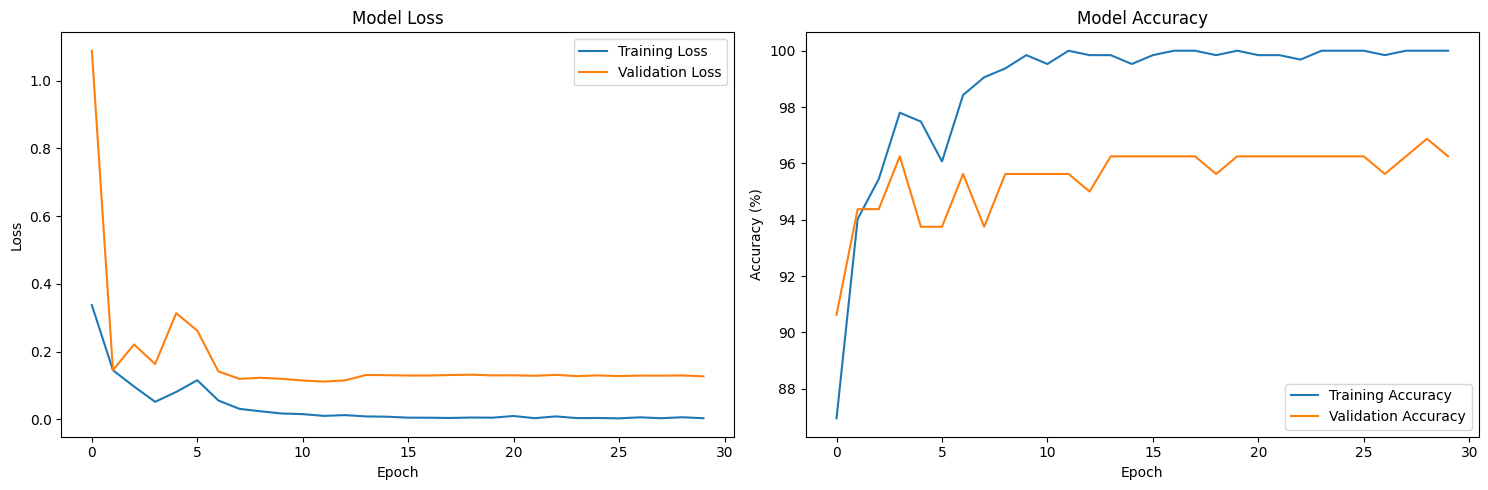

📈 Classification Report:
              precision    recall  f1-score   support

       apple       0.95      0.97      0.96        76
      orange       0.98      0.95      0.96        84

    accuracy                           0.96       160
   macro avg       0.96      0.96      0.96       160
weighted avg       0.96      0.96      0.96       160


🧪 Testing on sample images...
🍎 Apple sample: {'predicted_class': 'apple', 'confidence': 0.9955089092254639, 'probabilities': {'apple': 0.9955089092254639, 'orange': 0.004491123836487532}}
🍊 Orange sample: {'predicted_class': 'orange', 'confidence': 0.99982750415802, 'probabilities': {'apple': 0.0001724736939650029, 'orange': 0.99982750415802}}
💾 Saving model for deployment...
✅ Model saved as qualcomm_apple_orange_classifier.pt and qualcomm_apple_orange_classifier.pkl
📁 Files available in /kaggle/working/

✅ Training completed successfully!
📁 Files ready for download:
   - qualcomm_apple_orange_classifier.pt
   - qualcomm_apple_orange_cla

In [6]:
# Main training execution
def main():
    """Main training function"""
    print("🍎🍊 Apple vs Orange Classification with Qualcomm AI Hub")
    print("=" * 60)
    
    # Initialize classifier
    classifier = QualcommAppleOrangeClassifier(model_name="mobilenet_v2")
    
    # Prepare data (adjust path to your dataset)
    data_path = "/kaggle/input/apple-vs-orange-binary-classification/fruit-dataset"
    
    # Check if dataset exists
    if not os.path.exists(data_path):
        print(f"❌ Dataset not found at {data_path}")
        print("Please check your dataset path")
        return
    
    print(f"📂 Dataset path: {data_path}")
    
    # Prepare datasets
    train_loader, val_loader = classifier.prepare_data(data_path)
    
    # Train model
    training_history = classifier.train_model(num_epochs=30, learning_rate=0.001)
    
    # Evaluate model
    evaluation_results = classifier.evaluate_model()
    
    # Test on sample images
    print("\n🧪 Testing on sample images...")
    apple_path = os.path.join(data_path, "apple")
    orange_path = os.path.join(data_path, "orange")
    
    if os.path.exists(apple_path):
        sample_apple = os.path.join(apple_path, os.listdir(apple_path)[0])
        apple_result = classifier.predict_single_image(sample_apple)
        print(f"🍎 Apple sample: {apple_result}")
    
    if os.path.exists(orange_path):
        sample_orange = os.path.join(orange_path, os.listdir(orange_path)[0])
        orange_result = classifier.predict_single_image(sample_orange)
        print(f"🍊 Orange sample: {orange_result}")
    
    # Save model for deployment
    classifier.save_model_for_deployment('qualcomm_apple_orange_classifier')
    
    print("\n✅ Training completed successfully!")
    print("📁 Files ready for download:")
    print("   - qualcomm_apple_orange_classifier.pt")
    print("   - qualcomm_apple_orange_classifier.pkl")
    print("   - confusion_matrix.png")
    print("   - training_history.png")

# Run the training
if __name__ == "__main__":
    main()